In [1]:
import os
import keras
import tensorflow as tf
import vis
import matplotlib.pyplot as plt
import numpy as np
print("keras      {}".format(keras.__version__))
print("tensorflow {}".format(tf.__version__))
from keras.applications.resnet50 import preprocess_input
from keras.models import load_model
from glob import glob
from keras.preprocessing.image import load_img, img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam 
from keras import backend as K
from skimage.io import imsave, imshow
import pylab

Using TensorFlow backend.


keras      2.3.1
tensorflow 2.2.0


In [2]:
path_folder = '/Users/flavio/Downloads/mapa_ativacao/'
model = load_model(path_folder+'model_lenet.h5')
layer_name = 'conv_3'
last_layer_name = 'classification'

In [3]:
def visualization_map(img, model, last_layer_name, layer_name, path_save_im):
    img_ = img_to_array(img)
    img_ = img_/255
    y_pred = model.predict(img_[np.newaxis,...][:,:,:,1].reshape((1,256,256,1)))
    
    layer_idx = utils.find_layer_idx(model, last_layer_name)
    model.layers[layer_idx].activation = keras.activations.linear
    model = utils.apply_modifications(model)

    penultimate_layer_idx = utils.find_layer_idx(model, layer_name)
    grad_top1  = visualize_cam(model, layer_idx, None, img_[np.newaxis,...][:,:,:,1].reshape((1,256,256,1)), 
                               penultimate_layer_idx = penultimate_layer_idx, 
                               backprop_modifier = None, grad_modifier = None)
    
    return plot_map(grad_top1, img, path_save_im)
    
def plot_map(grads, _img, path_save_im):
    fig, axes = pylab.subplots(1,2,figsize=(15,5))
    frame = pylab.gca()
    
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[0].imshow(np.uint8(img_to_array(_img)[:,:,0]),cmap='jet',vmin = 0, vmax = 255) 
        
    axes[1].set_title('Grad cam')
    axes[1].imshow(_img)
    i = axes[1].imshow(np.uint8(grads),cmap='jet',alpha=0.5,vmin = 0, vmax = 255)
    fig.colorbar(i)
    
    frame.axes.get_xaxis().set_ticks([])
    frame.axes.get_yaxis().set_ticks([])
    
    fig.savefig(path_save_im + '.png')
    return fig

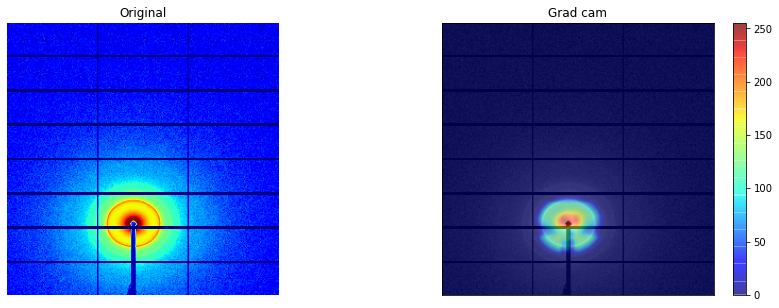

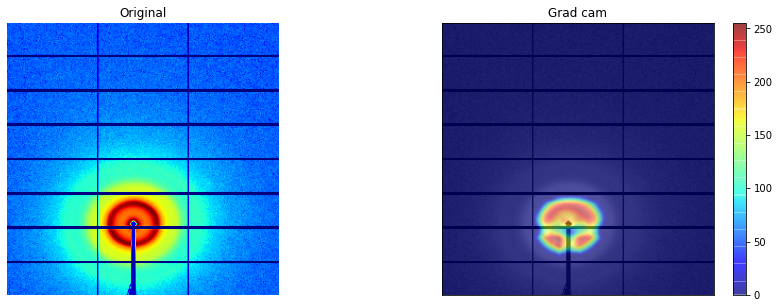

In [4]:
imagens = sorted(glob(path_folder + 'SAXS_small/*.tif'))

folder_save = path_folder + '/SAXS_small_save'


if not os.path.isdir(folder_save):
    os.mkdir(folder_save)

for name in imagens:
    name_save = name.split('/')[-1].split('.')[0]
    img = load_img(name)
    i = visualization_map(img, model, last_layer_name, layer_name, folder_save + name_save)
    